CSV files found: 16


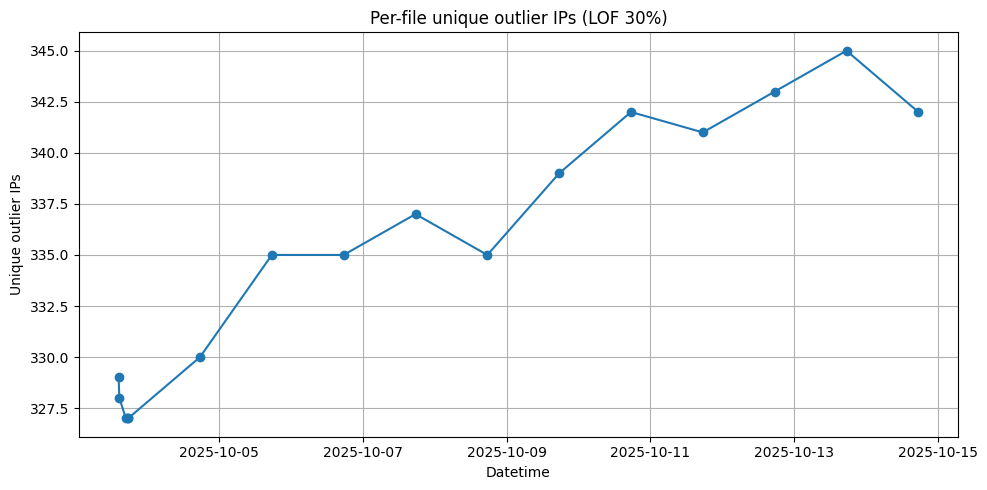

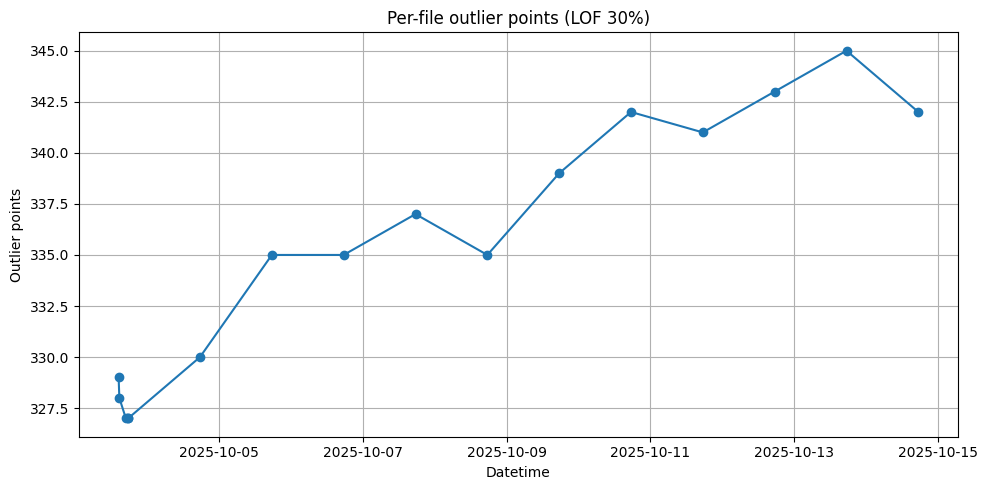

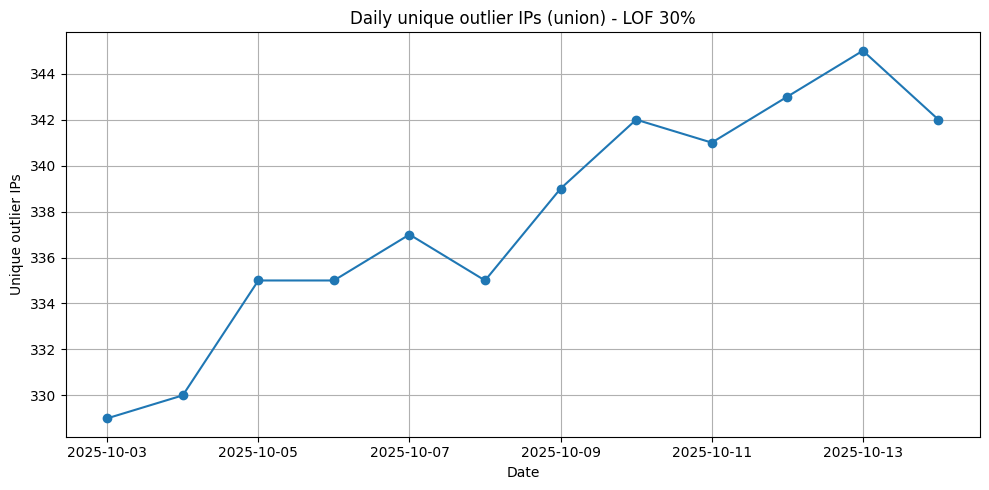


--- Per-file summary (head) ---
                         file            datetime  outlier_ip_count  outlier_point_count  n_neighbors  n_rows
20251003142418-TorIP_geocoded 2025-10-03 14:24:18               329                  329           75    1135
20251003143810-TorIP_geocoded 2025-10-03 14:38:10               328                  328           75    1134
20251003164852-TorIP_geocoded 2025-10-03 16:48:52               327                  327           75    1132
20251003172946-TorIP_geocoded 2025-10-03 17:29:46               327                  327           75    1132
20251003173524-TorIP_geocoded 2025-10-03 17:35:24               327                  327           75    1132
20251004173514-TorIP_geocoded 2025-10-04 17:35:14               330                  330           75    1138
20251005173523-TorIP_geocoded 2025-10-05 17:35:23               335                  335           75    1128
20251006173520-TorIP_geocoded 2025-10-06 17:35:20               335                  33

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os, zipfile, re, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# ===== Settings =====
RATE = 0.30  # Outlier rate 30%

# Console UTF-8 (mojibake guard for print)
try:
    sys.stdout.reconfigure(encoding="utf-8")
except Exception:
    pass

# Matplotlib minus sign fix (mojibake guard)
plt.rcParams["axes.unicode_minus"] = False

ZIP_PATH    = "./isolation_forest.zip"   # adjust if needed
EXTRACT_DIR = "./isolation_forest_all"

# ===== Unzip =====
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# ===== Collect CSVs =====
csv_files = []
for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))
csv_files.sort()
print(f"CSV files found: {len(csv_files)}")

# ===== Helpers =====
IPV4_RE = re.compile(r"\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b")

def detect_lat_lon_columns(columns):
    # exact first
    lat = next((c for c in columns if c.lower() in ["latitude", "lat", "y", "lat_deg"]), None)
    lon = next((c for c in columns if c.lower() in ["longitude", "lon", "lng", "x", "long", "lon_deg"]), None)
    # fallback partial
    if lat is None:
        lat = next((c for c in columns if "lat" in c.lower()), None)
    if lon is None:
        lon = next((c for c in columns if ("lon" in c.lower()) or ("lng" in c.lower()) or ("longi" in c.lower())), None)
    return lat, lon

def detect_ip_column(df: pd.DataFrame):
    cols  = list(df.columns)
    lower = [c.lower() for c in cols]
    prefs = ["ip", "ip_address", "source_ip", "src_ip", "dst_ip", "ipaddr", "address", "remote_ip", "client_ip"]
    for p in prefs:
        if p in lower:
            return cols[lower.index(p)]
    for c in cols:
        if "ip" in c.lower():
            return c
    # text columns: pick one with >=10% ipv4 presence
    text_cols = [c for c in cols if df[c].dtype == "object"]
    best_col, best_rate = None, 0.0
    sample_n = min(200, len(df))
    for c in text_cols:
        rate = df[c].astype(str).head(sample_n).apply(lambda s: IPV4_RE.search(s) is not None).mean()
        if rate > best_rate:
            best_rate, best_col = rate, c
    if best_col is not None and best_rate >= 0.10:
        return best_col
    return None

def filename_to_datetime(fname: str):
    m14 = re.search(r"(\d{14})", fname)
    if m14:
        return pd.to_datetime(m14.group(1), format="%Y%m%d%H%M%S", errors="coerce")
    m8 = re.search(r"(\d{8})", fname)
    if m8:
        return pd.to_datetime(m8.group(1), format="%Y%m%d", errors="coerce")
    return pd.NaT

def extract_outlier_ip_set(df: pd.DataFrame, is_out_mask: np.ndarray) -> set:
    """Return unique IPv4 set from outlier rows; falls back to scanning text columns."""
    ip_col = detect_ip_column(df)
    ips = set()
    if ip_col:
        for s in df.loc[is_out_mask, ip_col].astype(str):
            m = IPV4_RE.search(s)
            if m:
                ips.add(m.group(0))
        return ips
    # fallback: scan concatenated text columns
    text_cols = [c for c in df.columns if df[c].dtype == "object"]
    if text_cols:
        concat_text = df[text_cols].astype(str).agg(" ".join, axis=1)
        for s in concat_text[is_out_mask]:
            m = IPV4_RE.search(s)
            if m:
                ips.add(m.group(0))
    return ips

# ===== Main (LOF with RATE) =====
per_file = []

for path in csv_files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[SKIP] read error {path}: {e}")
        continue

    lat_col, lon_col = detect_lat_lon_columns(df.columns)
    if not lat_col or not lon_col:
        print(f"[SKIP] {os.path.basename(path)}: lat/lon not found -> {list(df.columns)}")
        continue

    # Clean
    df = df.copy()
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df = df.dropna(subset=[lat_col, lon_col])
    df = df[(df[lat_col].between(-90, 90)) & (df[lon_col].between(-180, 180))]
    if len(df) < 5:
        print(f"[SKIP] {os.path.basename(path)}: too few rows (n={len(df)})")
        continue

    X = df[[lon_col, lat_col]].to_numpy()
    n = len(X)

    # LOF (30%): unify contamination and neighbor scale
    n_neighbors = max(10, min(75, int(n * RATE)))
    if n_neighbors >= n:
        n_neighbors = max(5, n - 1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=RATE)
    y_pred = lof.fit_predict(X)   # 1=inlier, -1=outlier
    is_out = (y_pred == -1)

    ip_set = extract_outlier_ip_set(df, is_out)
    outlier_ip_count    = len(ip_set)       # unique outlier IPs
    outlier_point_count = int(is_out.sum()) # outlier coordinates (reference)

    fname = os.path.basename(path).replace(".csv", "")
    dt    = filename_to_datetime(fname)
    date  = pd.to_datetime(dt.date()) if pd.notna(dt) else pd.NaT

    per_file.append({
        "file": fname,
        "datetime": dt,
        "date": date,
        "outlier_ip_count": outlier_ip_count,
        "outlier_point_count": outlier_point_count,
        "ip_set": ip_set,
        "n_neighbors": n_neighbors,
        "n_rows": n
    })

per_file_df = pd.DataFrame(per_file).dropna(subset=["datetime"]).sort_values("datetime")

if per_file_df.empty:
    print("No valid data to analyze (lat/lon missing or date parse failed).")
else:
    # ---- Plot per-file (datetime) unique outlier IP count ----
    plt.figure(figsize=(10, 5))
    plt.plot(per_file_df["datetime"], per_file_df["outlier_ip_count"], marker="o")
    plt.title(f"Per-file unique outlier IPs (LOF {int(RATE*100)}%)")
    plt.xlabel("Datetime")
    plt.ylabel("Unique outlier IPs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (reference) outlier points count
    plt.figure(figsize=(10, 5))
    plt.plot(per_file_df["datetime"], per_file_df["outlier_point_count"], marker="o")
    plt.title(f"Per-file outlier points (LOF {int(RATE*100)}%)")
    plt.xlabel("Datetime")
    plt.ylabel("Outlier points")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- Daily union (unique IPs across files on same day) ----
    day_union = {}
    for _, row in per_file_df.dropna(subset=["date"]).iterrows():
        d = row["date"]
        s = row["ip_set"] if isinstance(row["ip_set"], set) else set()
        if d not in day_union:
            day_union[d] = set()
        day_union[d] |= s

    per_day = [{"date": d, "unique_outlier_ips_union": len(day_union[d])} for d in sorted(day_union.keys())]
    per_day_df = pd.DataFrame(per_day)

    if not per_day_df.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(per_day_df["date"], per_day_df["unique_outlier_ips_union"], marker="o")
        # ASCII-only title to avoid mojibake
        plt.title(f"Daily unique outlier IPs (union) - LOF {int(RATE*100)}%")
        plt.xlabel("Date")
        plt.ylabel("Unique outlier IPs")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ---- Print heads for sanity check ----
    print("\n--- Per-file summary (head) ---")
    print(per_file_df[["file","datetime","outlier_ip_count","outlier_point_count","n_neighbors","n_rows"]].head(10).to_string(index=False))

    if not per_day_df.empty:
        print("\n--- Daily union (unique outlier IPs) ---")
        print(per_day_df.to_string(index=False))
